<a href="https://colab.research.google.com/github/LuigTi/CNN_NAS2/blob/main/CNN_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Dataset Class

In [41]:
class DigitsDataset(Dataset):
    '''
    Digit database from scikit-learn
    '''

    def __init__(self, mode = "train", transforms = None):
        digits = load_digits()

        #select the first 1000 datapoints as training set
        if mode == "train": 
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]

        #select 350 datapoints as training set
        elif mode == "val": 
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        
        #select the remaining datapoints as test set
        else: 
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]       
        #reshape datapoints from vector to matrix
        sample_x = sample_x.reshape(1, 8, 8) 
        sample_y = self.targets[idx]
        
        if torch.cuda.is_available(): #move on gpu if possible
          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = torch.from_numpy(np.array(sample_y)).to("cuda")

        return (sample_x, sample_y)

### CNN Class

In [42]:
class CNN(nn.Module):
    '''
    following the structure of:
      Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax

    ● Conv2d:
        ○ Number of filters: 8, 16, 32
        ○ kernel=(3,3), stride=1, padding=1 OR kernel=(5,5), stride=1, padding=2
    ● f(.):
        ○ ReLU OR sigmoid OR tanh OR softplus OR ELU
    ● Pooling:
        ○ 2x2 OR Identity
        ○ Average OR Maximum
    ● Linear 1:
        ○ Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    '''
    #rinomina tutto, 
    
    def __init__(self, 
                 conv_out = 8, # Number of filters: 8, 16, 32
                 kernel_params = 0, #0 OR 1
                      #0=> kernel=(3,3), stride=1, padding=1
                      #1=> kernel=(5,5), stride=1, padding=2
                 f1 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
                 f2 = "ReLU", #possible activation functions:
                      #ReLU OR Sigmoid OR Tanh OR Softplus OR ELU                 
                 pool_size = 2,  #2, identity
                 pooling = "avg", # avg, max
                 linear_out = 10 #10,20,30,40,50,60,70,80,90,100
                 ):
        super(CNN, self).__init__()


        #adjust the parameters depending on the input
        self.conv_out = conv_out 
        if kernel_params == 0: #kernel=(3,3), stride=1, padding=1
            self.kernel_size = 3 
            self.padding = 1 
        else:
            self.kernel_size = 5 
            self.padding = 2

        if pool_size == 2:
            self.pool_size = 2
        else:
            self.pool_size = "identity"

        self.linear_out = linear_out # Number of neurons

        #find the size of the tensor cefore entering the fully connected layer
        if True:
          #find the size after the convolutional layers
          size = 8 - self.kernel_size + 2 * self.padding + 1
          #find the size after the pooling layer
          size = (size - self.pool_size) / (self.pool_size) + 1
          #find the size after flattening
          size = int(size**2 * self.conv_out)


        #convolutional layers
        self.cnn =  nn.Conv2d(in_channels = 1, out_channels = conv_out, kernel_size = self.kernel_size, stride = 1, padding = self.padding)

        #activation function 1
        if f1 == "ReLU":    
            self.activation1 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        elif f1 == "Sigmoid":
            self.activation1 = nn.Sigmoid()
        if f1 == "Tanh":    
            self.activation1 = nn.Tanh() # or sigmoid, tanh, softplus, elu
        elif f1 == "Softplus":
            self.activation1 = nn.Softplus()
        elif f1 == "ELU":
            self.activation1 = nn.ELU()

        #pooling
        if pooling == "avg":
            self.pool = nn.AvgPool2d(kernel_size = pool_size)
        else:
            self.pool = nn.MaxPool2d(kernel_size = pool_size)
       
        #fully connected layer 1
        self.linear1 = nn.Linear(in_features = size, out_features = self.linear_out)

        #activation function 2
        if f2 == "ReLU":    
            self.activation2 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        elif f2 == "Sigmoid":
            self.activation2 = nn.Sigmoid()
        if f2 == "Tanh":    
            self.activation2 = nn.Tanh() # or sigmoid, tanh, softplus, elu
        elif f2 == "Softplus":
            self.activation2 = nn.Softplus()
        elif f2 == "ELU":
            self.activation2 = nn.ELU()

        #fully connected layer 1
        self.linear2 = nn.Linear(in_features = self.linear_out, out_features = 10)
        #softmax
        self.softmax = nn.LogSoftmax(dim=1)

        #loss funtion
        self.nll = nn.NLLLoss(reduction="none") 
    
    #classify method to find the prediccion of a datapoint
    def classify(self, x):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        #find prediction
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    #foward method for the foward pass
    def forward(self, x, y, reduction="avg"):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        
        #find the loss (it has as input the log_prob and targets)
        loss = self.nll(log_prob, y)
        #reduction for loss over a batch (either summ or mean)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    #find how many classifying mistakes were made
    def missclassified_datapoints(self, predictions, targets):
        #number of differences in the two vectors
        return torch.sum(predictions != targets) 

### Train and Evaluation Loops (one epoch) and Plot Function

In [43]:
def train_loop(dataloader, model, optimizer):

    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model on train mode
    model.train()

    #for datapoint and target in dataloader
    for (X, y) in dataloader:

        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
    
    #print average loss and average classification error 
    print("\033[95mTRAINING\033[0m")
    print(f"        average train loss => {average_loss}")
    print(f"        average classification error => {average_ce}")
    print("")
    
    return average_loss, average_ce


In [44]:
def evaluation_loop(dataloader, model, optimizer, mode = "validation"):


    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model to eval mode
    model.eval()


    #to not save the gradients
    with torch.no_grad():
      #for datapoint and target in dataloader
      #tqdm to make progress bar
      for (X, y) in dataloader:


        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints



    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
      
      
    #print average loss and average classification error 
    if mode == "validation":
      print("\033[95mVALIDATION\033[0m")
    else:
      print("\033[92mTESTING\033[0m")

    print(f"        average {mode} loss => {average_loss}")
    print(f"        average {mode} classification error => {average_ce}")
    print("")

    return average_loss, average_ce


In [45]:
#function to plot
def plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_list = None, test_ce_list = None):
    #number of epoches
    n_epochs = len(train_loss_list)
    # Plotting train loss
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")

    # Plotting train classification error
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")

    # Plotting validation loss
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")

    # Plotting validation classification error
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")

    if test_loss_list != None and test_ce_list != None:
      # Plotting test loss
      plt.plot(range(1, n_epochs + 1), [test_loss_list] * n_epochs, label="Test Loss", linestyle="--")

      # Plotting test classification error
      plt.plot(range(1, n_epochs + 1), [test_ce_list] * n_epochs, label="Test Classification Error", linestyle="--")

    # Set plot labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Classification Error")
    plt.title("Training and Evaluation Results")

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

### Dataloaders and Full Training and Testing

In [46]:
#training, validation and test sets.
train_set = DigitsDataset(mode="train")
val_set = DigitsDataset(mode="val")
test_set = DigitsDataset(mode="test")

#data loaders.
training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

#initializa model and optimizer
cnn = CNN().to("cuda")
opt = torch.optim.Adamax(cnn.parameters(), lr=1e-3, weight_decay=1e-5)

In [49]:
def full_train_loop(number_epoch = 20, testing = True, training_loader = None, val_loader = None, test_loader = None):

    #initialize empty lists
    train_loss_list = []
    train_ce_list = []
    val_loss_list =[]
    val_ce_list =[]
    test_loss_list =[]
    test_ce_list =[]

    #for number of epoches
    #tqdm to make progress bar
    for i in tqdm(range(number_epoch)):

      print(f"\033[96mEPOCH NUMBER {i}\033[0m")
      train_loss, train_ce =  train_loop(dataloader = training_loader, model = cnn, optimizer = opt)
      train_loss_list.append(train_loss)
      train_ce_list.append(train_ce)

      val_loss, val_ce = evaluation_loop(dataloader = val_loader, model = cnn, optimizer = opt)
      val_loss_list.append(val_loss)
      val_ce_list.append(val_ce)

    if testing == True:
      test_loss, test_ce = evaluation_loop(dataloader = test_loader, model = cnn, optimizer = opt, mode = "test")
      test_loss_list.append(test_loss)
      test_ce_list.append(test_ce)
    else:
      test_loss_list = None
      test_ce_list = None

    #plot graphs
    plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_result, test_ce_list)

    if testing == True:
      return min(test_loss_list), max(test_ce_list)
    else:
      return  min(val_loss_list), max(val_ce_list)


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 2.3225128650665283
        average classification error => 0.9010000228881836

VALIDATION
        average validation loss => 2.2910118103027344
        average validation classification error => 0.8971428275108337

EPOCH NUMBER 1
TRAINING
        average train loss => 2.2397990226745605
        average classification error => 0.9010000228881836

VALIDATION
        average validation loss => 2.2216575145721436
        average validation classification error => 0.8942856788635254

EPOCH NUMBER 2
TRAINING
        average train loss => 2.17065167427063
        average classification error => 0.8640000224113464

VALIDATION
        average validation loss => 2.152132272720337
        average validation classification error => 0.8342856764793396

EPOCH NUMBER 3
TRAINING
        average train loss => 2.0963001251220703
        average classification error => 0.7790000438690186

VALIDATION
        average validation loss => 2.072062730789184

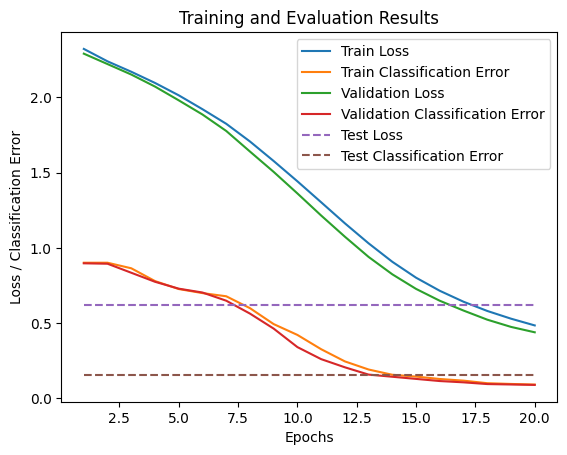

In [50]:
loop = full_train_loop(number_epoch = 20, testing = True, training_loader = training_loader, val_loader = val_loader, test_loader = test_loader)

### Neuroevolutionary Algorithm Class


GIVEN THAT THE FOLLOWING ARE THE POSSIBILITIES:

conv_out = 8, 16, 32

* kernel_params = 0, 1

          0=> kernel=(3,3), stride=1, padding=1
          
          1=> kernel=(5,5), stride=1, padding=2


* f1 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU     


* f2 = ReLU OR Sigmoid OR Tanh OR Softplus OR ELU          


* pool_size = 2, identity

* pooling =  avg, max

* linear_out = 10,20,30,40,50,60,70,80,90,100

THE FOLLOWING IS THE ENCODING:

**[conv_out, kernel_params, f1, f2, pool_size, pooling, linear_out]**

where their **RANGE** is:

  * conv_out => 0-1-2

  * kernel_params => 0-1
  
  * f1 => 0-1-2-3-4
  
  * f2 => 0-1-2-3-4
  
  * pool_size => 0-1
  
  * pooling => 0-1

  * linear_out => 0-1-2-3-4-5-6-7-8-9


In [51]:
class EA(object):
    def __init__(self, pop_size = 10, p_parents = 0.8, nr_parents = 5, nr_candidate_child = 12):
      
        self.pop_size = pop_size #size of a population
        self.p_parents = p_parents #percentage of top indivuals from old generation taken as possible parents
        self.nr_parents = nr_parents #parents taken from each each generation
        self.nr_candidate_child = nr_candidate_child #candidate children after each recombination

        #max value of each entry (min is always 0)
        self.conv_out_max = 2
        self.kernel_params_max = 1
        self.f1_max = 4
        self.f2_max = 4
        self.pool_size_max = 1
        self.pooling_max = 2
        self.linear_out = 9


        #training, validation and test sets
        self.train_set = DigitsDataset(mode="train")
        self.val_set = DigitsDataset(mode="val")
        #data loaders
        self.training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
        self.val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
       
      
    def parent_selection(self, x_old, f_old):
        x_parents = x_old
        f_parents = f_old

        #sort parents from best to worst fistness
        index = np.argsort(f_parents) 
        x_parents = x_parents[index]
        f_parents = f_parents[index]
        
        #p = hyperparameter
        p = float(self.p_parents)

        #the number of individuals in p percent
        range_p = int(self.pop_size * p)
        parents_list=[]

        #for self.nr_parents times, sample with replacement (from the 100p best individuals from the old generaton)
        for i in range(self.nr_parents):
          #random index within the top range
          top_index = np.random.choice(range(range_p), size=1)
          #get individual at the randomly selected index from the top range
          random_top_ind = x_parents[top_index]
          #add the new parent to the list
          parents_list.append(random_top_ind)
        #turn list into numpy array
        array_parents = np.stack(parents_list).reshape((self.nr_parents, 4))    

        return x_parents, f_parents



    def recombination(self, x_parents, f_parents):
        candidate_children = []
        #since each loop 2 children are made => nr_candidate_child/2
        for i in range(int(self.nr_candidate_child/2)):
          #pick two random parents
          idx1, idx2 = np.random.choice(self.pop_size, size=2, replace=False)
          parent1 = x_parents[idx1]
          parent2 = x_parents[idx2]
          #pick a random number from 1 to 5
          random_number = np.random.randint(1, 6)

          half1_1 = x_parents[idx1][:random_number]
          half1_2 = x_parents[idx1][random_number:]
          half2_1 = x_parents[idx2][:random_number]
          half2_2 = x_parents[idx2][random_number:]

          child1 = np.concatenate((half1_1, half2_2))
          child2 = np.concatenate((half2_1, half1_2))
          candidate_children.append(child1)
          candidate_children.append(child2)

          #TODO: FIX reshape
          #turn list into numpy array of the right size 
          candidates = np.stack(candidate_children).reshape((int(self.nr_candidate_child), 7))

        return candidates



    def mutation(self, x_children):    
          ex = [self.conv_out_max, self.kernel_params_max, self.f1_max, self.f2_max,self.pool_size_max, self.pooling_max,self.linear_out ]
          #pick a random number from 0 to 6
          random_number = np.random.randint(0, 7)

          #if the value of the entry picked is 0, add one
          if x_children[random_number] == 0:
             x_children[random_number] = x_children[random_number] + 1
          #if the value of the entry picked is the max, subtract 1
          elif x_children[random_number] == ex[random_number]:
             x_children[random_number] = x_children[random_number] - 1
          #if the value of the entry picked is not the max nor the min, either add or subtract 1
          else:
            random_choice = np.random.choice([-1, 1])
            x_children[random_number] = x_children[random_number] + random_choice

          return x_children 



    def survivor_selection(self, x_old, x_children, f_old, f_children):
        #combine parent and children populations
        x = np.vstack([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        
        #select the best individuals based on their fitness
        idx_sorted = np.argsort(f)
        x_sorted = x[idx_sorted]
        
        #keep the top individuals as the new population
        x_survivors = x_sorted[:self.pop_size]
        f_survivors = f[idx_sorted][:self.pop_size]
        return x_survivors, f_survivors



    def evaluate(self, x):
        y = self.nn_from_genotype(x)
        cnn_to_evaluate =  CNN(conv_out = y[0], 
                               kernel_params = y[1], 
                               f1 = y[2],
                               f2 = y[3],               
                               pool_size = y[4],
                               pooling = y[5],
                               linear_out = y[6] )
        
        validation_loss, validation_ce = full_train_loop(number_epoch = 20, testing = False, training_loader = self.training_loader, val_loader = self.val_loader, test_loader = self.test_loader)                 
        
        #fitness = validation_ce + 0.01*(Np/Nmax)
        return validation_ce

    def nn_from_genotype(self, genotype):
        '''
        transform genotype into parameters usable to create the CNN
        it follows the schema described above
        '''

        y = []
        #conv_out = 8, 16, 32
        if genotype[0] == 0:
          y.append(8)
        elif genotype[0] == 1:
          y.append(16)
        else:
          y.append(32)

        #kernel params= 0 or 1
        y.append(genotype[1])

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[2] == 0:
          y.append("ReLU")
        elif genotype[2] == 1:
          y.append("Sigmoid")
        elif genotype[2] == 2:
          y.append("Tanh")
        elif genotype[2] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #f1= ReLU OR Sigmoid OR Tanh OR Softplus OR ELU
        if genotype[3] == 0:
          y.append("ReLU")
        elif genotype[3] == 1:
          y.append("Sigmoid")
        elif genotype[3] == 2:
          y.append("Tanh")
        elif genotype[3] == 3:
          y.append("Softplus")
        else:
          y.append("ELU")

        #pool_size= 2 or identity
        y.append(2)

        #pooling = avg, max
        if genotype[5] == 0:
          y.append("avg")
        else:
          y.append("max")
        
        #linear_out = 10,20,30,40,50,60,70,80,90,100
        a =  genotype[6]
        y.append((a+1)*10)
         #return the parameters 
        return y

    def step(self, x_old, f_old):

        x_parents, f_parents = self.parent_selection(x_old, f_old) # return a subset of the old population / parents and how fit they are

        x_children = self.recombination(x_parents, f_parents) # compute a set of INITIAL candidate solutions

        x_children = self.mutation(x_children)  # compute a set of FINAL candidate solutions, that are modified with perturbation

        f_children = self.evaluate(x_children) # compute the fitness of the FINAL candidate solutions

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children) # select the new population from the old population and the FINAL candidate solutions (or solely from the FINAL candidate solutions)<= commenting the code before implementing

        return x, f # return the new population and their fitness

In [52]:
ea = EA()